<a href="https://colab.research.google.com/github/dhanushka365/LSTM-AutoEncoders/blob/main/LSTM_Autoencodertest(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Start by creating a new Environment

- To create an environment: `conda create --name anomalydetection python=3.7`
- Activate environment: `conda activate anomalydetection`

### Install the required packages (if required)

- `conda install jupyter`
- `conda install pandas`
- `conda install tensorflow`
- `conda install scikit-learn`
- `conda install plotly`
- `conda install matplotlib`

## Steps to follow for Anomaly Detection:
<ol>
<li>Construct an LSTM Autoencoder on the stock price data, assuming there are no anomalies.</li>
<li>Generate the error threshold on training dataset.</li>
<li>Detect Anomaly using the threshold on test dataset.</li>
</ol>


## Setup

In [68]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df = pd.read_csv('/content/drive/MyDrive/Anomaly/GE.csv')

## Quick look at data

In [71]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,251.000000,251.846161,248.692307,251.615387,151.990097,1819805
1,2004-08-20,251.230774,252.307693,249.923080,251.153839,151.711288,2114996
2,2004-08-23,251.384613,251.846161,249.692307,250.076920,151.060822,1742286
3,2004-08-24,251.538467,251.923080,249.307693,251.000000,151.618332,2062099
4,2004-08-25,250.153839,253.769226,249.384613,252.230774,152.361862,2046239


**We will deal with the closing price for each day.**

In [72]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close']]

In [73]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4117 non-null   object 
 1   Close   4117 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.5+ KB


**Data Time Period**

In [74]:
df['Date'].min(), df['Date'].max()

('2004-08-19', '2020-12-23')

## Visualize the data

In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

## Data Preprocessing

#### 1. Train - test split

In [76]:
train = df.loc[df['Date'] <= '2015-12-24']
test = df.loc[df['Date'] > '2015-12-24']
train.shape, test.shape

((2859, 2), (1258, 2))

#### 2. Data Scaling

In [77]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



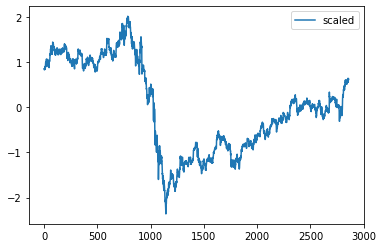

In [78]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [79]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (2829, 30, 1)
Testing input shape:  (1228, 30, 1)


In [82]:
X_train[2828]

array([[0.60362822],
       [0.54064993],
       [0.55546839],
       [0.56534737],
       [0.56040789],
       [0.58510508],
       [0.55423359],
       [0.60239342],
       [0.59374924],
       [0.60239342],
       [0.56534737],
       [0.56534737],
       [0.51348286],
       [0.54188475],
       [0.51718754],
       [0.52459666],
       [0.58140065],
       [0.56658219],
       [0.54435461],
       [0.57893079],
       [0.60115836],
       [0.55299853],
       [0.55299853],
       [0.56040789],
       [0.64190907],
       [0.58880976],
       [0.55546839],
       [0.57028687],
       [0.58140065],
       [0.63820441]])

In [83]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [84]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

## Train Model

In [85]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
80/80 [==============================] - 10s 80ms/step - loss: 0.1299 - val_loss: 0.0179
Epoch 2/100
80/80 [==============================] - 5s 67ms/step - loss: 0.0641 - val_loss: 0.0243
Epoch 3/100
80/80 [==============================] - 5s 68ms/step - loss: 0.0807 - val_loss: 0.0155
Epoch 4/100
80/80 [==============================] - 6s 69ms/step - loss: 0.0474 - val_loss: 0.0149
Epoch 5/100
80/80 [==============================] - 5s 67ms/step - loss: 0.0396 - val_loss: 0.0167
Epoch 6/100
80/80 [==============================] - 5s 66ms/step - loss: 0.0401 - val_loss: 0.0162
Epoch 7/100
80/80 [==============================] - 5s 66ms/step - loss: 0.0395 - val_loss: 0.0158
Epoch 8/100
80/80 [==============================] - 5s 66ms/step - loss: 0.0364 - val_loss: 0.0149
Epoch 9/100
80/80 [==============================] - 5s 67ms/step - loss: 0.0365 - val_loss: 0.0159
Epoch 10/100
80/80 [==============================] - 5s 66ms/step - loss: 0.0350 - val_loss: 0.015

#### Plot Training - Validation loss

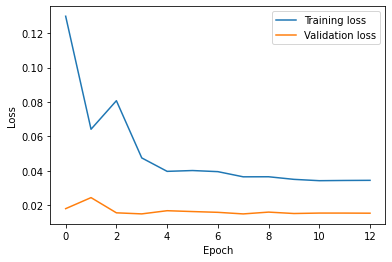

In [86]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Reconstruction error threshold: 0.6094106085490701


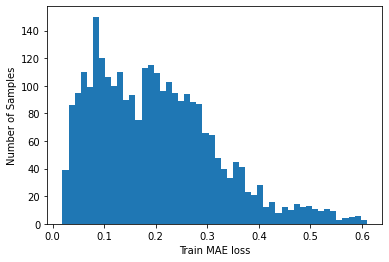

In [107]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

### Reconstruction error threshold: 0.48992275269204094

## Predict Anomalies on test data using threshold

39/39 [==============================] - 1s 19ms/step


Text(0, 0.5, 'Number of samples')

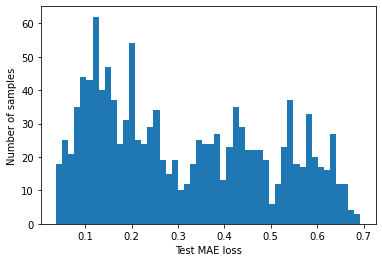

In [88]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [89]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [90]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
2889,2016-02-10,0.310965,0.153724,0.609411,False
2890,2016-02-11,0.206001,0.148298,0.609411,False
2891,2016-02-12,0.306025,0.167246,0.609411,False
2892,2016-02-16,0.380117,0.149952,0.609411,False
2893,2016-02-17,0.439391,0.115381,0.609411,False


In [109]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [98]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
3621,2019-01-08,-2.126664,0.621881,0.609411,True
3622,2019-01-09,-2.134073,0.628505,0.609411,True
3623,2019-01-10,-2.079739,0.629173,0.609411,True
3624,2019-01-11,-2.079739,0.638887,0.609411,True
3625,2019-01-14,-2.084678,0.642575,0.609411,True


In [113]:
anomalies.shape

(81, 5)

In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Close'], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['Close'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()